## Question 5.0

In [12]:
import torch.nn.functional as F
import torch.nn as nn
import torch

class CNNClassifier(nn.Module):
    def __init__(self, embedding_vectors, k1=3, k2=4, n1=100, n2=100):
        super(CNNClassifier, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_vectors)
        embedding_dim = embedding_vectors.size(1)

        # Convolutional layers
        # (in_channels, out_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, n1, (k1, embedding_dim), bias=False)
        self.conv2 = nn.Conv2d(1, n2, (k2, embedding_dim), bias=False)

        # Fully connected layer
        self.fc = nn.Linear(n1 + n2, 1)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        x = x.transpose(0, 1)

        # Add an extra dimension for the channel
        x = x.unsqueeze(1)

        # Apply Convolutional layers and ReLU activation
        x1 = F.relu(self.conv1(x)).squeeze(3)
        x2 = F.relu(self.conv2(x)).squeeze(3)

        # Max pooling over the sentence length
        x1 = F.max_pool1d(x1, x1.size(2)).squeeze(2)
        x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)

        # Concatenate the outputs
        x = torch.cat((x1, x2), 1)

        # Pass through the fully connected layer
        x = self.fc(x).squeeze(1)
        
        return x



In [5]:
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd

# TextDataset is Described in Section 3.3 of Assignment 2

class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, split="train"):
        data_path = "../data/"
        df = pd.read_csv(os.path.join(data_path, f"{split}.tsv"), sep="\t")

        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X 
        self.Y = torch.tensor(Y)
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx] 
    
# my_collate_function prepares batches
# it also pads each batch with zeroes.

def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function 
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device), 
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [6]:
class Args:
    def __init__(self, batch_size):
        self.batch_size = batch_size

args = Args(batch_size=32)

#   fix seed
torch.manual_seed(2)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ("Using device:", device)

### 3.3 Processing of the data ###
# 3.3.1
# The first time you run this will download a 862MB size file to .vector_cache/glove.6B.zip
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100
                                
# 3.3.2

train_dataset = TextDataset(glove, "train")
val_dataset = TextDataset(glove, "validation")
test_dataset = TextDataset(glove, "test")
overfit_dataset = TextDataset(glove, "overfit")
    
# 3.3.3
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=args.batch_size, 
    shuffle=False, 
    collate_fn=lambda batch: my_collate_function(batch, device))

validation_dataloader = torch.utils.data.DataLoader(
    dataset=val_dataset, 
    batch_size=args.batch_size, 
    shuffle=False, 
    collate_fn=lambda batch: my_collate_function(batch, device))

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=args.batch_size,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device))

overfit_dataloader = torch.utils.data.DataLoader(
    dataset=overfit_dataset,
    batch_size=args.batch_size,
    shuffle=True,
    collate_fn=lambda batch: my_collate_function(batch, device))

Using device: cpu


## Question 5.1

In [14]:
# set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# instantiate the model
model = CNNClassifier(glove.vectors, k1=2, n1=50, k2=4, n2=50).to(device)

# define the loss function and the optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# train the model
num_epochs = 10  # number epoch to train
best_train_acc = 0

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct = 0
    total = 0
    
    for batch in overfit_dataloader:  # using the overfit_dataloader for overfitting
        text, labels = batch
        text, labels = text.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(text)
        
        loss = criterion(outputs, labels.float())
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        
        # calculate accuracy
        predictions = torch.round(torch.sigmoid(outputs))
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    if train_acc > best_train_acc:
        best_train_acc = train_acc

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {train_acc:.2f}%")

print(f"Best Training Accuracy: {best_train_acc:.2f}%")


Epoch 1/10, Loss: 1.4132, Accuracy: 50.00%
Epoch 2/10, Loss: 1.2742, Accuracy: 96.00%
Epoch 3/10, Loss: 1.2268, Accuracy: 70.00%
Epoch 4/10, Loss: 1.1659, Accuracy: 78.00%
Epoch 5/10, Loss: 1.0696, Accuracy: 98.00%
Epoch 6/10, Loss: 1.0121, Accuracy: 100.00%
Epoch 7/10, Loss: 0.9440, Accuracy: 100.00%
Epoch 8/10, Loss: 0.9090, Accuracy: 100.00%
Epoch 9/10, Loss: 0.8335, Accuracy: 100.00%
Epoch 10/10, Loss: 0.7971, Accuracy: 100.00%
Best Training Accuracy: 100.00%


## Question 5.2.1

In [15]:
def compute_accuracy_on_validation_set(model, validation_dataloader):
    model.eval()  # Set the model to evaluation mode
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():  # Deactivate gradients for the following code
        for text, labels in validation_dataloader:
            outputs = model(text)
            predictions = torch.round(torch.sigmoid(outputs))  # Convert model output to binary predictions
            correct_predictions += (predictions == labels).sum().item()
            total_predictions += labels.size(0)

    accuracy = correct_predictions / total_predictions
    return accuracy

In [24]:
best_val_accuracy = 0
best_params = {}

k1_values = [2, 3, 4, 5]
n1_values = [2, 4, 8, 16]
k2_values = [2, 3, 4, 5]
n2_values = [2, 4, 8, 16]
learning_rates = [1e-3, 1e-4]

for k1 in k1_values:
    for n1 in n1_values:
        for k2 in k2_values:
            for n2 in n2_values:
                for lr in learning_rates:
                    # Initialize and train your model with the current hyperparameters
                    # set the device
                    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

                    # instantiate the model
                    model = CNNClassifier(glove.vectors, k1=k1, n1=n1, k2=k2, n2=n2).to(device)

                    # define the loss function and the optimizer
                    criterion = nn.BCEWithLogitsLoss()
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

                    # train the model
                    num_epochs = 30  # number epoch to train
                    best_train_acc = 0

                    for epoch in range(num_epochs):
                        model.train()
                        epoch_loss = 0
                        correct = 0
                        total = 0
                        
                        for batch in train_dataloader:  
                            text, labels = batch
                            text, labels = text.to(device), labels.to(device)
                            
                            optimizer.zero_grad()
                            outputs = model(text)
                            
                            loss = criterion(outputs, labels.float())
                            loss.backward()
                            optimizer.step()

                            epoch_loss += loss.item()
                            
                            # calculate accuracy
                            predictions = torch.round(torch.sigmoid(outputs))
                            correct += (predictions == labels).sum().item()
                            total += labels.size(0)

                        train_acc = 100 * correct / total
                        if train_acc > best_train_acc:
                            best_train_acc = train_acc
                    
                    # Compute validation accuracy
                    val_accuracy = compute_accuracy_on_validation_set(model,validation_dataloader)
                    if val_accuracy > best_val_accuracy:
                        best_val_accuracy = val_accuracy
                        best_params = {'k1': k1, 'n1': n1, 'k2': k2, 'n2': n2, 'lr': lr}

print("Best Validation Accuracy:", best_val_accuracy)
print("Best Hyperparameters:", best_params)


Best Validation Accuracy: 0.918648310387985
Best Hyperparameters: {'k1': 3, 'n1': 4, 'k2': 2, 'n2': 16, 'lr': 0.001}


In [26]:
import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, num_epochs, optimizer, criterion, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        correct = 0
        total = 0

        for text, labels in train_loader:
            outputs = model(text)
            loss = criterion(outputs, labels.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            predicted = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = correct / total
        train_losses.append(total_loss / len(train_loader))
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for text, labels in val_loader:
                outputs = model(text)
                loss = criterion(outputs, labels.float())

                val_loss += loss.item()
                predicted = torch.round(torch.sigmoid(outputs))
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    return train_losses, val_losses, train_accuracies, val_accuracies

def plot_training_validation_curves(train_values, val_values, metric="Loss"):
    plt.plot(train_values, label=f'Training {metric}')
    plt.plot(val_values, label=f'Validation {metric}')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend()
    plt.title(f'Training and Validation {metric}')
    plt.show()


Epoch 1/20, Train Loss: 0.6330, Train Accuracy: 0.8061, Val Loss: 0.5751, Val Accuracy: 0.8786
Epoch 2/20, Train Loss: 0.4902, Train Accuracy: 0.9367, Val Loss: 0.4502, Val Accuracy: 0.8905
Epoch 3/20, Train Loss: 0.3640, Train Accuracy: 0.9397, Val Loss: 0.3618, Val Accuracy: 0.8961
Epoch 4/20, Train Loss: 0.2785, Train Accuracy: 0.9434, Val Loss: 0.3088, Val Accuracy: 0.8974
Epoch 5/20, Train Loss: 0.2231, Train Accuracy: 0.9506, Val Loss: 0.2764, Val Accuracy: 0.8974
Epoch 6/20, Train Loss: 0.1850, Train Accuracy: 0.9561, Val Loss: 0.2554, Val Accuracy: 0.9049
Epoch 7/20, Train Loss: 0.1572, Train Accuracy: 0.9623, Val Loss: 0.2409, Val Accuracy: 0.9049
Epoch 8/20, Train Loss: 0.1360, Train Accuracy: 0.9670, Val Loss: 0.2308, Val Accuracy: 0.9074
Epoch 9/20, Train Loss: 0.1192, Train Accuracy: 0.9725, Val Loss: 0.2235, Val Accuracy: 0.9086
Epoch 10/20, Train Loss: 0.1055, Train Accuracy: 0.9770, Val Loss: 0.2183, Val Accuracy: 0.9105
Epoch 11/20, Train Loss: 0.0942, Train Accuracy: 

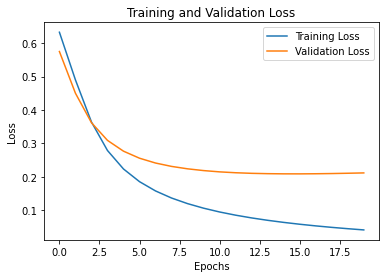

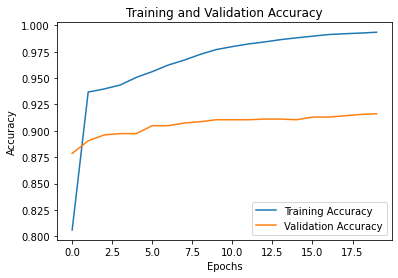

In [61]:
model = CNNClassifier(glove.vectors, k1=2, n1=4, k2=4, n2=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, validation_dataloader, num_epochs, optimizer, criterion, device)
plot_training_validation_curves(train_losses, val_losses, metric="Loss")
plot_training_validation_curves(train_accuracies, val_accuracies, metric="Accuracy")

## Question 5.2.2

In [29]:
import torch.nn.functional as F
import torch.nn as nn
import torch

class CNNClassifier(nn.Module):
    def __init__(self, embedding_vectors, k1=3, k2=4, n1=100, n2=100):
        super(CNNClassifier, self).__init__()
        
        # Embedding layer
        self.embedding = nn.Embedding.from_pretrained(embedding_vectors, freeze=False)
        embedding_dim = embedding_vectors.size(1)

        # Convolutional layers
        # (in_channels, out_channels, kernel_size)
        self.conv1 = nn.Conv2d(1, n1, (k1, embedding_dim), bias=False)
        self.conv2 = nn.Conv2d(1, n2, (k2, embedding_dim), bias=False)

        # Fully connected layer
        self.fc = nn.Linear(n1 + n2, 1)

    def forward(self, x):
        # Embedding
        x = self.embedding(x)
        x = x.transpose(0, 1)

        # Add an extra dimension for the channel
        x = x.unsqueeze(1)

        # Apply Convolutional layers and ReLU activation
        x1 = F.relu(self.conv1(x)).squeeze(3)
        x2 = F.relu(self.conv2(x)).squeeze(3)

        # Max pooling over the sentence length
        x1 = F.max_pool1d(x1, x1.size(2)).squeeze(2)
        x2 = F.max_pool1d(x2, x2.size(2)).squeeze(2)

        # Concatenate the outputs
        x = torch.cat((x1, x2), 1)

        # Pass through the fully connected layer
        x = self.fc(x).squeeze(1)
        
        return x

Epoch 1/20, Train Loss: 0.6616, Train Accuracy: 0.6795, Val Loss: 0.6288, Val Accuracy: 0.7947
Epoch 2/20, Train Loss: 0.5868, Train Accuracy: 0.8323, Val Loss: 0.5495, Val Accuracy: 0.8417
Epoch 3/20, Train Loss: 0.5017, Train Accuracy: 0.8602, Val Loss: 0.4686, Val Accuracy: 0.8554
Epoch 4/20, Train Loss: 0.4258, Train Accuracy: 0.8738, Val Loss: 0.4063, Val Accuracy: 0.8586
Epoch 5/20, Train Loss: 0.3696, Train Accuracy: 0.8833, Val Loss: 0.3639, Val Accuracy: 0.8648
Epoch 6/20, Train Loss: 0.3298, Train Accuracy: 0.8884, Val Loss: 0.3348, Val Accuracy: 0.8705
Epoch 7/20, Train Loss: 0.3006, Train Accuracy: 0.8958, Val Loss: 0.3138, Val Accuracy: 0.8786
Epoch 8/20, Train Loss: 0.2777, Train Accuracy: 0.9039, Val Loss: 0.2977, Val Accuracy: 0.8824
Epoch 9/20, Train Loss: 0.2588, Train Accuracy: 0.9091, Val Loss: 0.2849, Val Accuracy: 0.8880
Epoch 10/20, Train Loss: 0.2426, Train Accuracy: 0.9133, Val Loss: 0.2743, Val Accuracy: 0.8892
Epoch 11/20, Train Loss: 0.2282, Train Accuracy: 

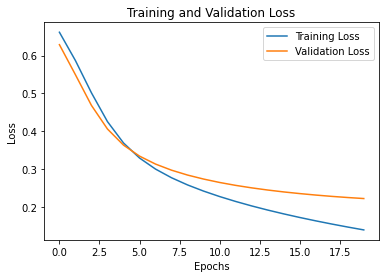

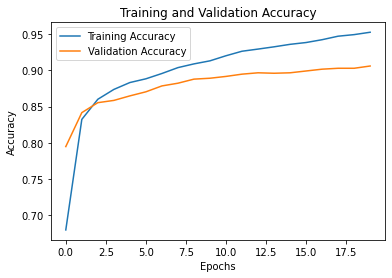

In [59]:
model = CNNClassifier(glove.vectors, k1=2, n1=4, k2=4, n2=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 20
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_dataloader, validation_dataloader, num_epochs, optimizer, criterion, device)
plot_training_validation_curves(train_losses, val_losses, metric="Loss")
plot_training_validation_curves(train_accuracies, val_accuracies, metric="Accuracy")
torch.save(model.state_dict(), "model_CNN.pt")

## Question 5.3

In [34]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def print_closest_cosine_words(vec, n=5):
    # Compute the cosine similarity between the input vector and all the words
    similarities = cosine_similarity(vec.reshape(1, -1), glove.vectors)
    
    # find the n most similar words
    top_indices = np.argsort(similarities[0])[::-1][:n]

    # print the most similar words and their similarities
    for idx in top_indices:
        similarity = similarities[0][idx]
        print(glove.itos[idx], "\t%5.2f" % similarity)

In [58]:
glove = torchtext.vocab.GloVe(name="6B",dim=100) # embedding size = 100

def print_closest_cosine_words(vec:str, n:int):
    '''
    print out N-most similar word using cosine similarity
    '''
    dists = torch.cosine_similarity(glove.vectors, vec.unsqueeze(0))
    lst = sorted(enumerate(dists.numpy()), key=lambda x: x[1])
    out = []
    for idx, difference in lst[:-n-1:-1]:
        print(glove.itos[idx], "\t%5.2f" % difference)
        out.append([idx, difference])
    print('\n')
    return out 

state = torch.load('model_CNN.pt')  # load the model
print(state.keys())
kernel1 = state['conv1.weight'].squeeze().cpu().reshape(-1, 100)
kernel2 = state['conv2.weight'].squeeze().cpu().reshape(-1, 100)
kernels = torch.cat((kernel1, kernel2), 0)
c_s = dict()
for i in kernels:
    c_i = print_closest_cosine_words(i, 5)


odict_keys(['embedding.weight', 'conv1.weight', 'conv2.weight', 'fc.weight', 'fc.bias'])
funeral 	 0.56
fiancee 	 0.50
gunned 	 0.50
gunmen 	 0.49
slain 	 0.49


abducted 	 0.51
jailed 	 0.48
kidnapped 	 0.48
imprisoned 	 0.47
custody 	 0.46


physician-assisted 	 0.45
dejanews 	 0.45
netcentric 	 0.44
vitellia 	 0.43
novitiate 	 0.42


shavon 	 0.48
boukman 	 0.48
traz 	 0.48
tuho 	 0.47
nicholaus 	 0.46


( 	 0.59
founded 	 0.54
born 	 0.53
) 	 0.52
testthis 	 0.49


james.lileks 	 0.44
gunned 	 0.42
roommate 	 0.42
abducted 	 0.40
bill.walsh 	 0.40


navy 	 0.47
jamaica 	 0.45
jersey 	 0.45
rhode 	 0.45
former 	 0.45


abducted 	 0.49
kidnapped 	 0.48
bubenik 	 0.46
delhez 	 0.42
ruzica 	 0.42


hospice 	 0.42
sanatorium 	 0.40
locksmith 	 0.40
dispensary 	 0.39
technician 	 0.37


galardi 	 0.49
boukman 	 0.49
palczynski 	 0.48
mirax 	 0.47
damilola 	 0.46


( 	 0.49
joined 	 0.48
born 	 0.47
manager 	 0.46
prohertrib 	 0.46


attends 	 0.39
eugene 	 0.38
trustee 	 0.37
physician 	

## Question 5.4

### Just run each cell, one by one for each question part.